# Travelling Santas

now closed kaggle competition

with added benchmark TSP instances

In [1]:
#source = 'santas'
#source = 'tsp'
source = 200

num_clusters=20

In [2]:
import pandas as pd
import numpy as np
import random
import time

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


In [3]:
# read the TSP library format file
def read_tsp_file(filename):
    
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]

    #print(lines)
    
    chimneys = pd.DataFrame(columns=['X','Y'])
    
    for i in range(6, len(lines)-1):
        #print(lines[i])
        
        line = lines[i].strip().split()
        #x = int(line[1])
        #y = int(line[2])
        
        chimneys = chimneys.append({'X': line[1],
                                    'Y': line[2]}, 
                                   ignore_index=True)
        
    chimneys['X'] = pd.to_numeric(chimneys['X'])
    chimneys['Y'] = pd.to_numeric(chimneys['Y'])
    
    return chimneys

chimneys = read_tsp_file('C:/Users/joeba/OneDrive/Documents/ML/travelling salesman problem/a280.tsp')
chimneys

,X,Y
0,288,149
1,288,129
2,270,133
3,256,141
4,256,157
...,...,...
275,236,145
276,246,141
277,252,125
278,260,129


In [4]:
# source is either 'file', or an integer of the number of chimneys to randomly drop
if source == 'santas':

    dirpath = 'C:/Users/joeba/OneDrive/Documents/ML/travelling_santa/cities.csv'
    chimneys = pd.read_csv(dirpath, index_col=0)
    
elif source == 'tsp':

    chimneys = read_tsp_file('C:/Users/joeba/OneDrive/Documents/ML/travelling salesman problem/a280.tsp')
    
else:
    chimneys = pd.DataFrame(columns=['X','Y'])
    for i in range(0,source):
        chimneys = chimneys.append({'X': np.random.randint(low=0, high=5100), 
                                    'Y': np.random.randint(low=0, high=3398)}, 
                                   ignore_index=True)
        
print(np.max(chimneys['X']), np.max(chimneys['Y']))
chimneys.shape        

5092 3386


(200, 2)

In [5]:
chimneys

,X,Y
0,1031,3266
1,4754,2858
2,1078,3140
3,2920,2927
4,412,1998
...,...,...
195,4189,645
196,1940,2703
197,4078,2023
198,862,277


In [6]:
chimneys.dtypes

X    object
Y    object
dtype: object

In [7]:
# do a k-means clustering
%timeit
X = chimneys.values
kmeans = KMeans(n_clusters=num_clusters, random_state=1223)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
chimneys['cluster'] = y_pred

In [8]:
%%timeit
chimneys['cluster'].value_counts()

600 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
centroids

array([[1925.88888889, 1930.88888889],
       [4395.375     ,  598.6875    ],
       [3996.90909091, 1872.09090909],
       [2492.5       ,  366.75      ],
       [ 780.46153846, 2042.23076923],
       [ 708.45454545,  361.        ],
       [2857.66666667, 1405.88888889],
       [1295.88888889, 3128.66666667],
       [ 326.75      , 3041.5       ],
       [3013.22222222, 2427.44444444],
       [1096.30769231, 1165.46153846],
       [ 218.58333333, 1230.58333333],
       [4764.42857143, 1946.42857143],
       [4710.625     , 2959.25      ],
       [3410.07692308,  747.84615385],
       [3032.85714286, 3145.85714286],
       [1979.14285714, 1358.14285714],
       [3878.14285714, 2806.28571429],
       [2172.3       , 2775.7       ],
       [1812.4       ,  423.8       ]])

In [10]:
centroids[1][1]

598.6875

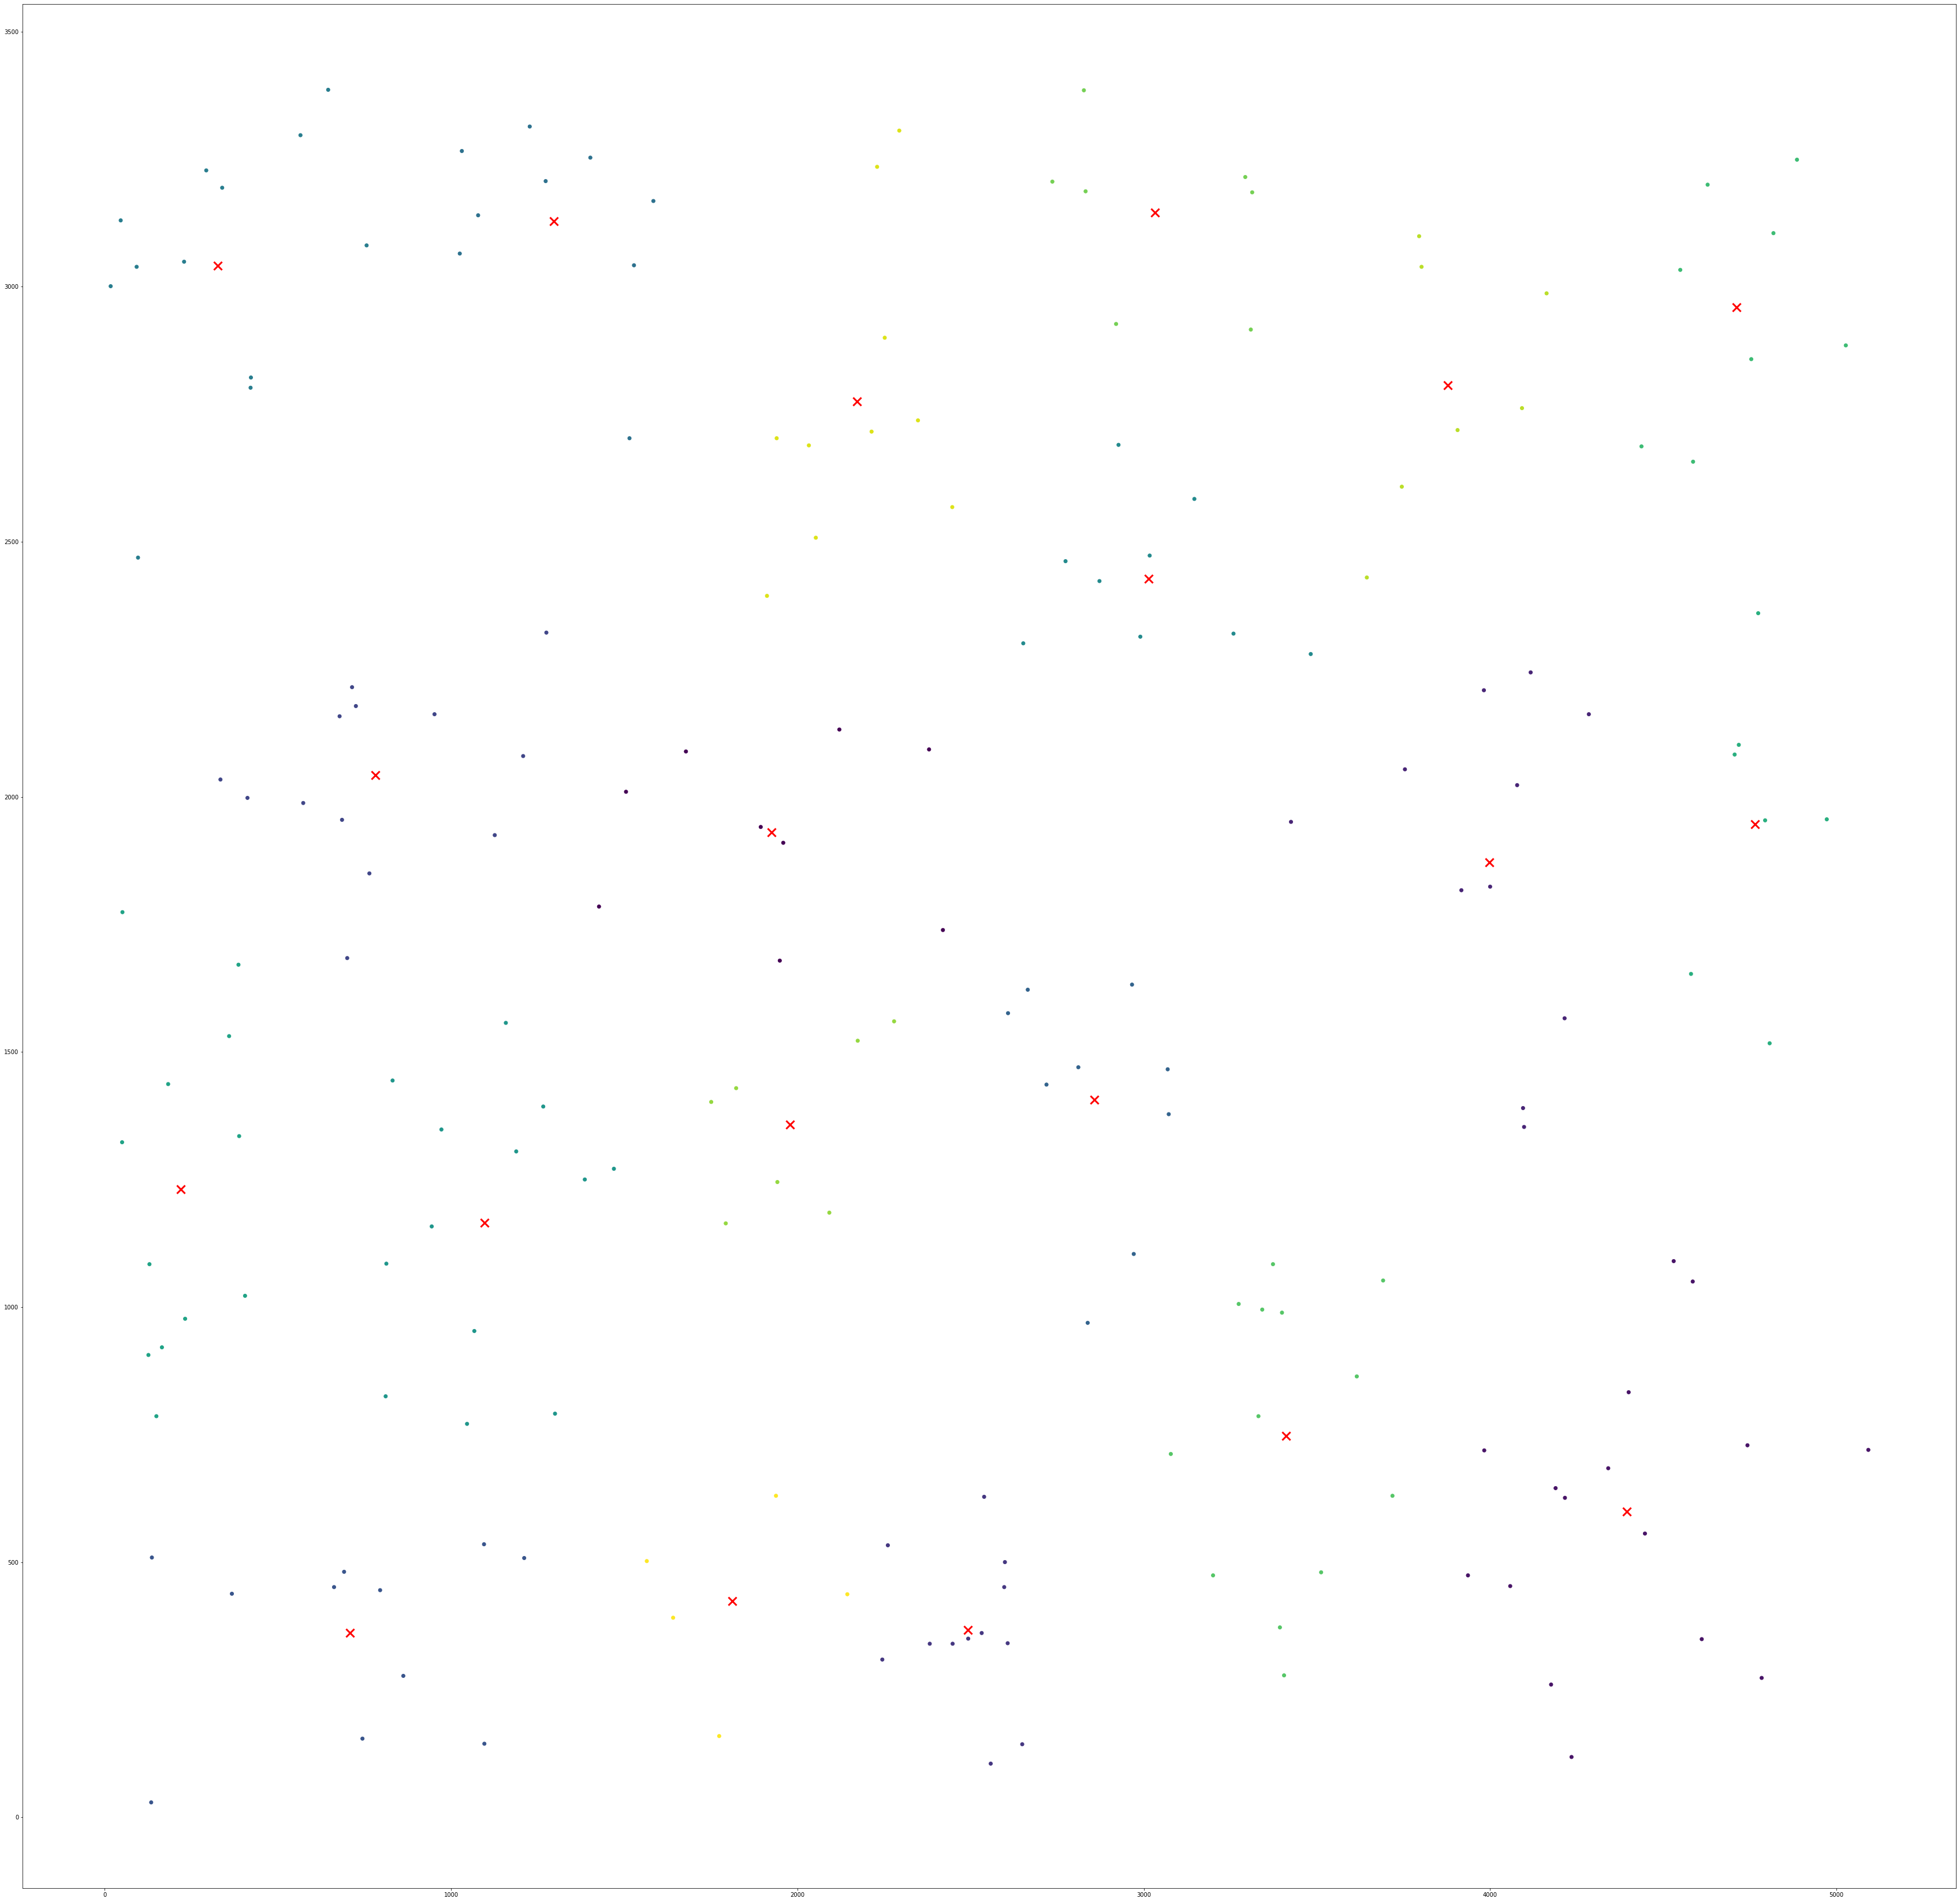

In [11]:

plt.figure(figsize=(60,60))
plt.scatter(x=chimneys['X'], y=chimneys['Y'], c=chimneys['cluster'])
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="x", s=200, linewidths=3, c='r', zorder=10)

plt.show()

In [12]:
# initial caluate distances
def calculate_distance(X, i, j):
    dist = np.sqrt((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2)
    return dist

L = len(centroids)-1
i = np.random.randint(0,L)
j = np.random.randint(0,L)

dist = calculate_distance(centroids, i, j)

print(i, j, dist)

0 16 575.2164827398648


In [13]:
# overload function - different arguments
#def calculate_distance(x1, y1, x2, y2):
#    dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
#    return dist

#calculate_distance(12,0, 15,3)

In [14]:
# make a centroids distance matrix
cdm = np.zeros((len(centroids), len(centroids)))
for i in range(len(centroids)):
    for j in range(i, len(centroids)):
        cdm[i][j] = calculate_distance(centroids, i, j)
        cdm[j][i] = cdm[i][j]
        
cdm

array([[   0.        , 2805.90844354, 2071.85469558, 1663.60410404,
        1150.82615083, 1986.62968467, 1069.50213986, 1353.35568308,
        1946.97257969, 1195.34982224, 1128.75329036, 1845.35095068,
        2838.58221848, 2968.54876722, 1898.00006158, 1643.63212838,
         575.21648274, 2139.53620172,  880.01377781, 1511.35589684],
       [2805.90844354,    0.        , 1334.29056918, 1916.95807714,
        3892.48204936, 3694.57410073, 1736.69830443, 4000.95097905,
        4745.63402516, 2292.31286324, 3347.39867828, 4224.32017855,
        1397.35698166, 2381.52007737,  996.52426182, 2888.68968574,
        2532.7751988 , 2267.38152178, 3111.50219039, 2588.88885205],
       [2071.85469558, 1334.29056918,    0.        , 2128.21473667,
        3220.94433818, 3619.02321532, 1230.94176338, 2979.00868852,
        3851.95864133, 1129.62710876, 2985.43355997, 3832.39840049,
         771.11104325, 1300.50193688, 1268.18699839, 1597.4594132 ,
        2082.1919158 ,  941.7140502 , 2036.101

In [15]:
cdm[0][1]

2805.9084435398395

In [16]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = cdm
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)

def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
        index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
    routes.append(route)
    return routes

In [17]:
def solve_tsp():
    
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)

    return get_routes(solution, routing, manager)

centroids_tsp_route = solve_tsp()

Objective: 18685 miles
Route for vehicle 0:
 0 -> 16 -> 19 -> 3 -> 6 -> 14 -> 1 -> 2 -> 12 -> 13 -> 17 -> 15 -> 9 -> 18 -> 7 -> 8 -> 4 -> 11 -> 5 -> 10 -> 0



In [18]:
centroids_tsp_route[0]

[0, 16, 19, 3, 6, 14, 1, 2, 12, 13, 17, 15, 9, 18, 7, 8, 4, 11, 5, 10, 0]

In [19]:
# find the halfway points
ctr = centroids_tsp_route[0]

halfways = np.zeros(shape=(len(ctr),2))

for i in range(len(ctr)-1):
    
    # what's the halfway point between each cluster
    a = ctr[i]
    b = ctr[i+1]
    halfways[i][0] = (centroids[a][0] + centroids[b][0]) / 2
    halfways[i][1] = (centroids[a][1] + centroids[b][1]) / 2
    
halfways

array([[1952.51587302, 1644.51587302],
       [1895.77142857,  890.97142857],
       [2152.45      ,  395.275     ],
       [2675.08333333,  886.31944444],
       [3133.87179487, 1076.86752137],
       [3902.72596154,  673.26682692],
       [4196.14204545, 1235.38920455],
       [4380.66883117, 1909.25974026],
       [4737.52678571, 2452.83928571],
       [4294.38392857, 2882.76785714],
       [3455.5       , 2976.07142857],
       [3023.03968254, 2786.65079365],
       [2592.76111111, 2601.57222222],
       [1734.09444444, 2952.18333333],
       [ 811.31944444, 3085.08333333],
       [ 553.60576923, 2541.86538462],
       [ 499.5224359 , 1636.40705128],
       [ 463.51893939,  795.79166667],
       [ 902.38111888,  763.23076923],
       [1511.0982906 , 1548.17521368],
       [   0.        ,    0.        ]])

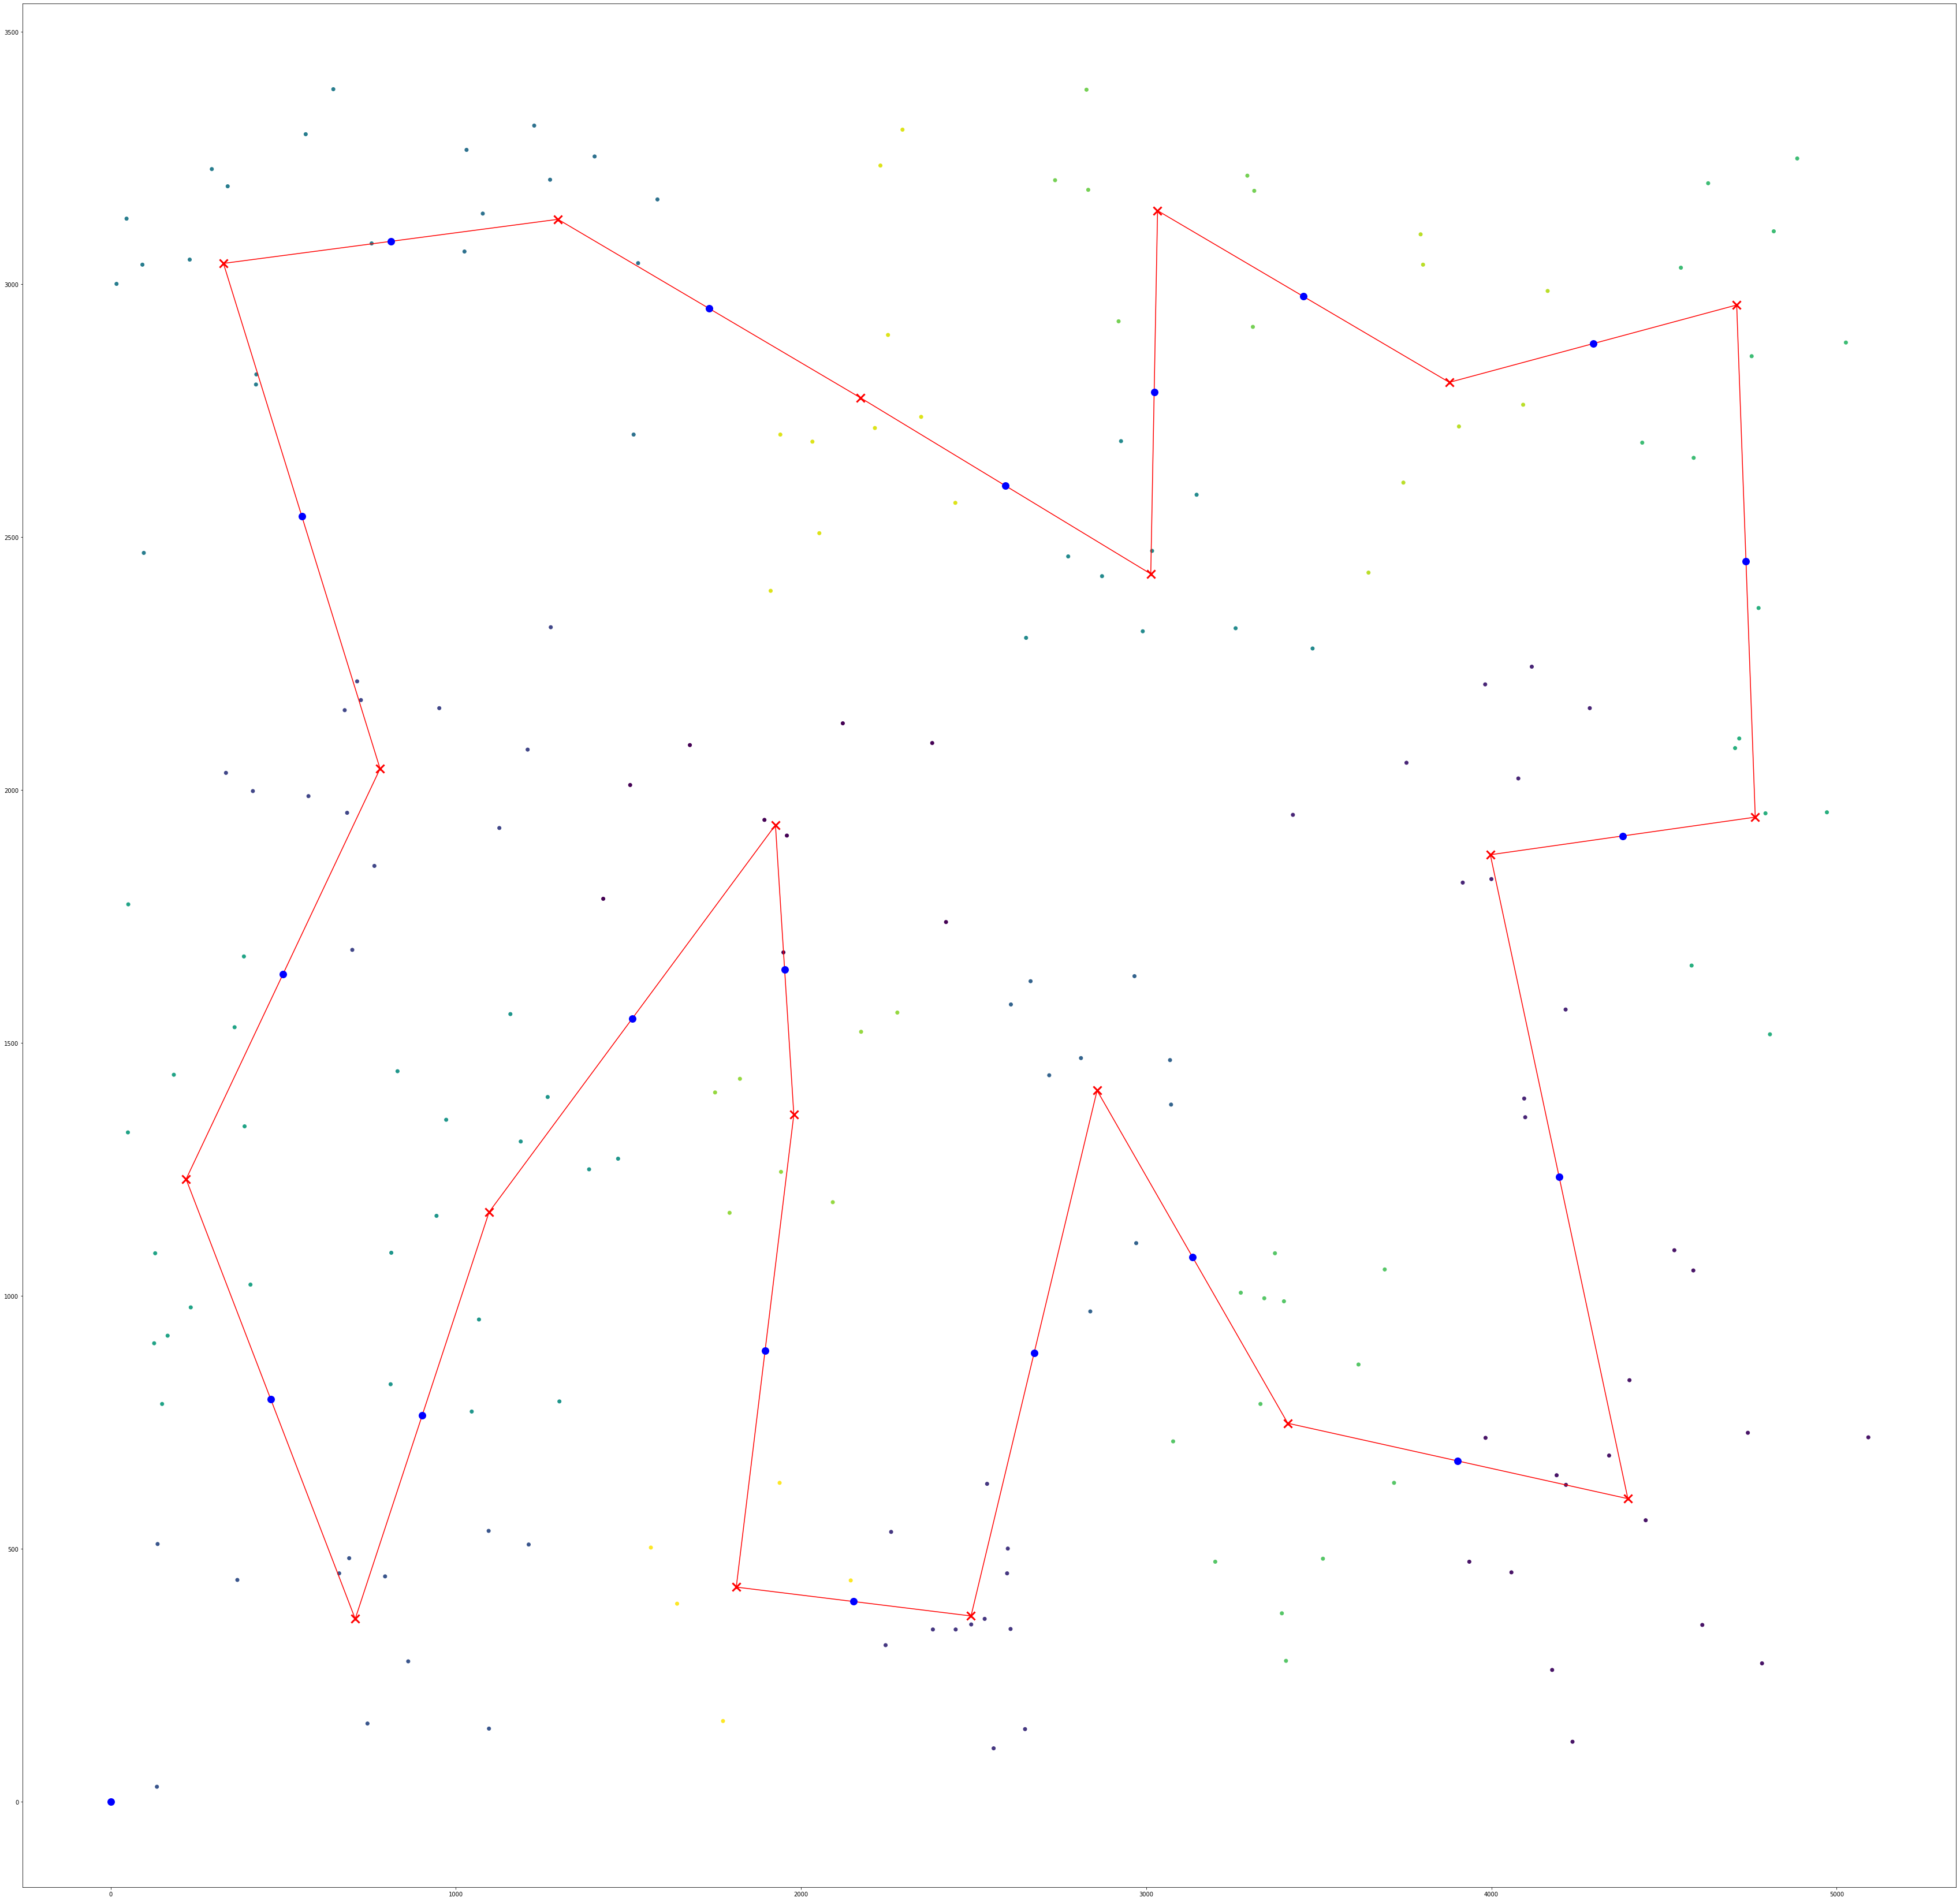

In [20]:
plt.figure(figsize=(60,60))

# nodes
plt.scatter(x=chimneys['X'], y=chimneys['Y'], c=chimneys['cluster'])
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="x", s=200, linewidths=3, c='r', zorder=10)
plt.scatter(x=halfways[:, 0], y=halfways[:, 1], marker="o", s=100, linewidths=3, c='b', zorder=10)

ctr = centroids_tsp_route[0]

# lines
for i in range(len(ctr)-1):
    a = ctr[i]
    b = ctr[i+1]
    plt.plot([centroids[a][0], centroids[b][0]], [centroids[a][1], centroids[b][1]], marker="1", c='r')

plt.show()

In [21]:
# find the closest node pair in adjacent clusters

links = []

# iterate over the route less 1
for i in range(len(ctr)-1):
    
    a = chimneys[chimneys['cluster'] == ctr[i]]
    b = chimneys[chimneys['cluster'] == ctr[i+1]]
    
    best_dist = 10.0E9
    best_ai = -1
    best_bi = -1
    best_ai_x = -1
    best_ai_y = -1
    best_bi_x = -1
    best_bi_y = -1
    
    for ai, ar in a.iterrows():
        for bi, br in b.iterrows():
            
            #print(ar[0], ar[1], br[0], br[1])
            #print(ctr[i], ctr[i+1], ai, bi, best_ai, best_bi, best_dist)
            
            dist = np.sqrt((ar[0] - br[0])**2 + (ar[1] - br[1])**2)
        
            if dist < best_dist:
                best_dist = dist
                best_ai = ai
                best_bi = bi
                best_ai_x = ar[0]
                best_ai_y = ar[1]
                best_bi_x = br[0]
                best_bi_y = br[1]
    
    print(ctr[i], ctr[i+1], best_ai, best_ai_x, best_ai_y, best_bi, best_bi_x, best_bi_y, best_dist)
    links.append([best_ai_x, best_ai_y, best_bi_x, best_bi_y])
    

0 16 92 2420 1739 67 2279 1560 227.86399452304877
16 19 86 1793 1164 23 1938 630 553.3362449722591
19 3 99 2144 437 19 2261 533 151.34397906755325
3 6 13 2539 628 126 2838 969 453.52177455994325
6 14 199 2971 1104 193 3274 1006 318.45407832213425
14 1 47 3718 630 121 3936 474 268.06715576511795
1 2 66 4530 1090 138 4098 1353 505.75982442262057
2 12 75 4215 1566 175 4580 1653 375.22526567383494
12 13 173 4774 2360 24 4586 2657 351.501066854711
13 17 115 4437 2687 9 4092 2762 353.0580688781946
17 15 180 3795 3099 14 3313 3185 489.61209135396155
15 9 3 2920 2927 111 2927 2690 237.10335299189677
9 18 42 2652 2301 189 2447 2568 336.62144910863896
18 7 196 1940 2703 122 1515 2703 425.0
7 8 62 1025 3065 88 756 3081 269.4754163184464
8 4 49 96 2469 159 334 2034 495.85179237348734
4 11 188 700 1684 149 386 1671 314.2689930616764
11 5 116 149 786 124 136 509 277.3048863615641
5 10 61 1095 535 65 1046 771 241.03319273494262
10 0 64 1158 1557 43 1427 1785 352.62586405424094


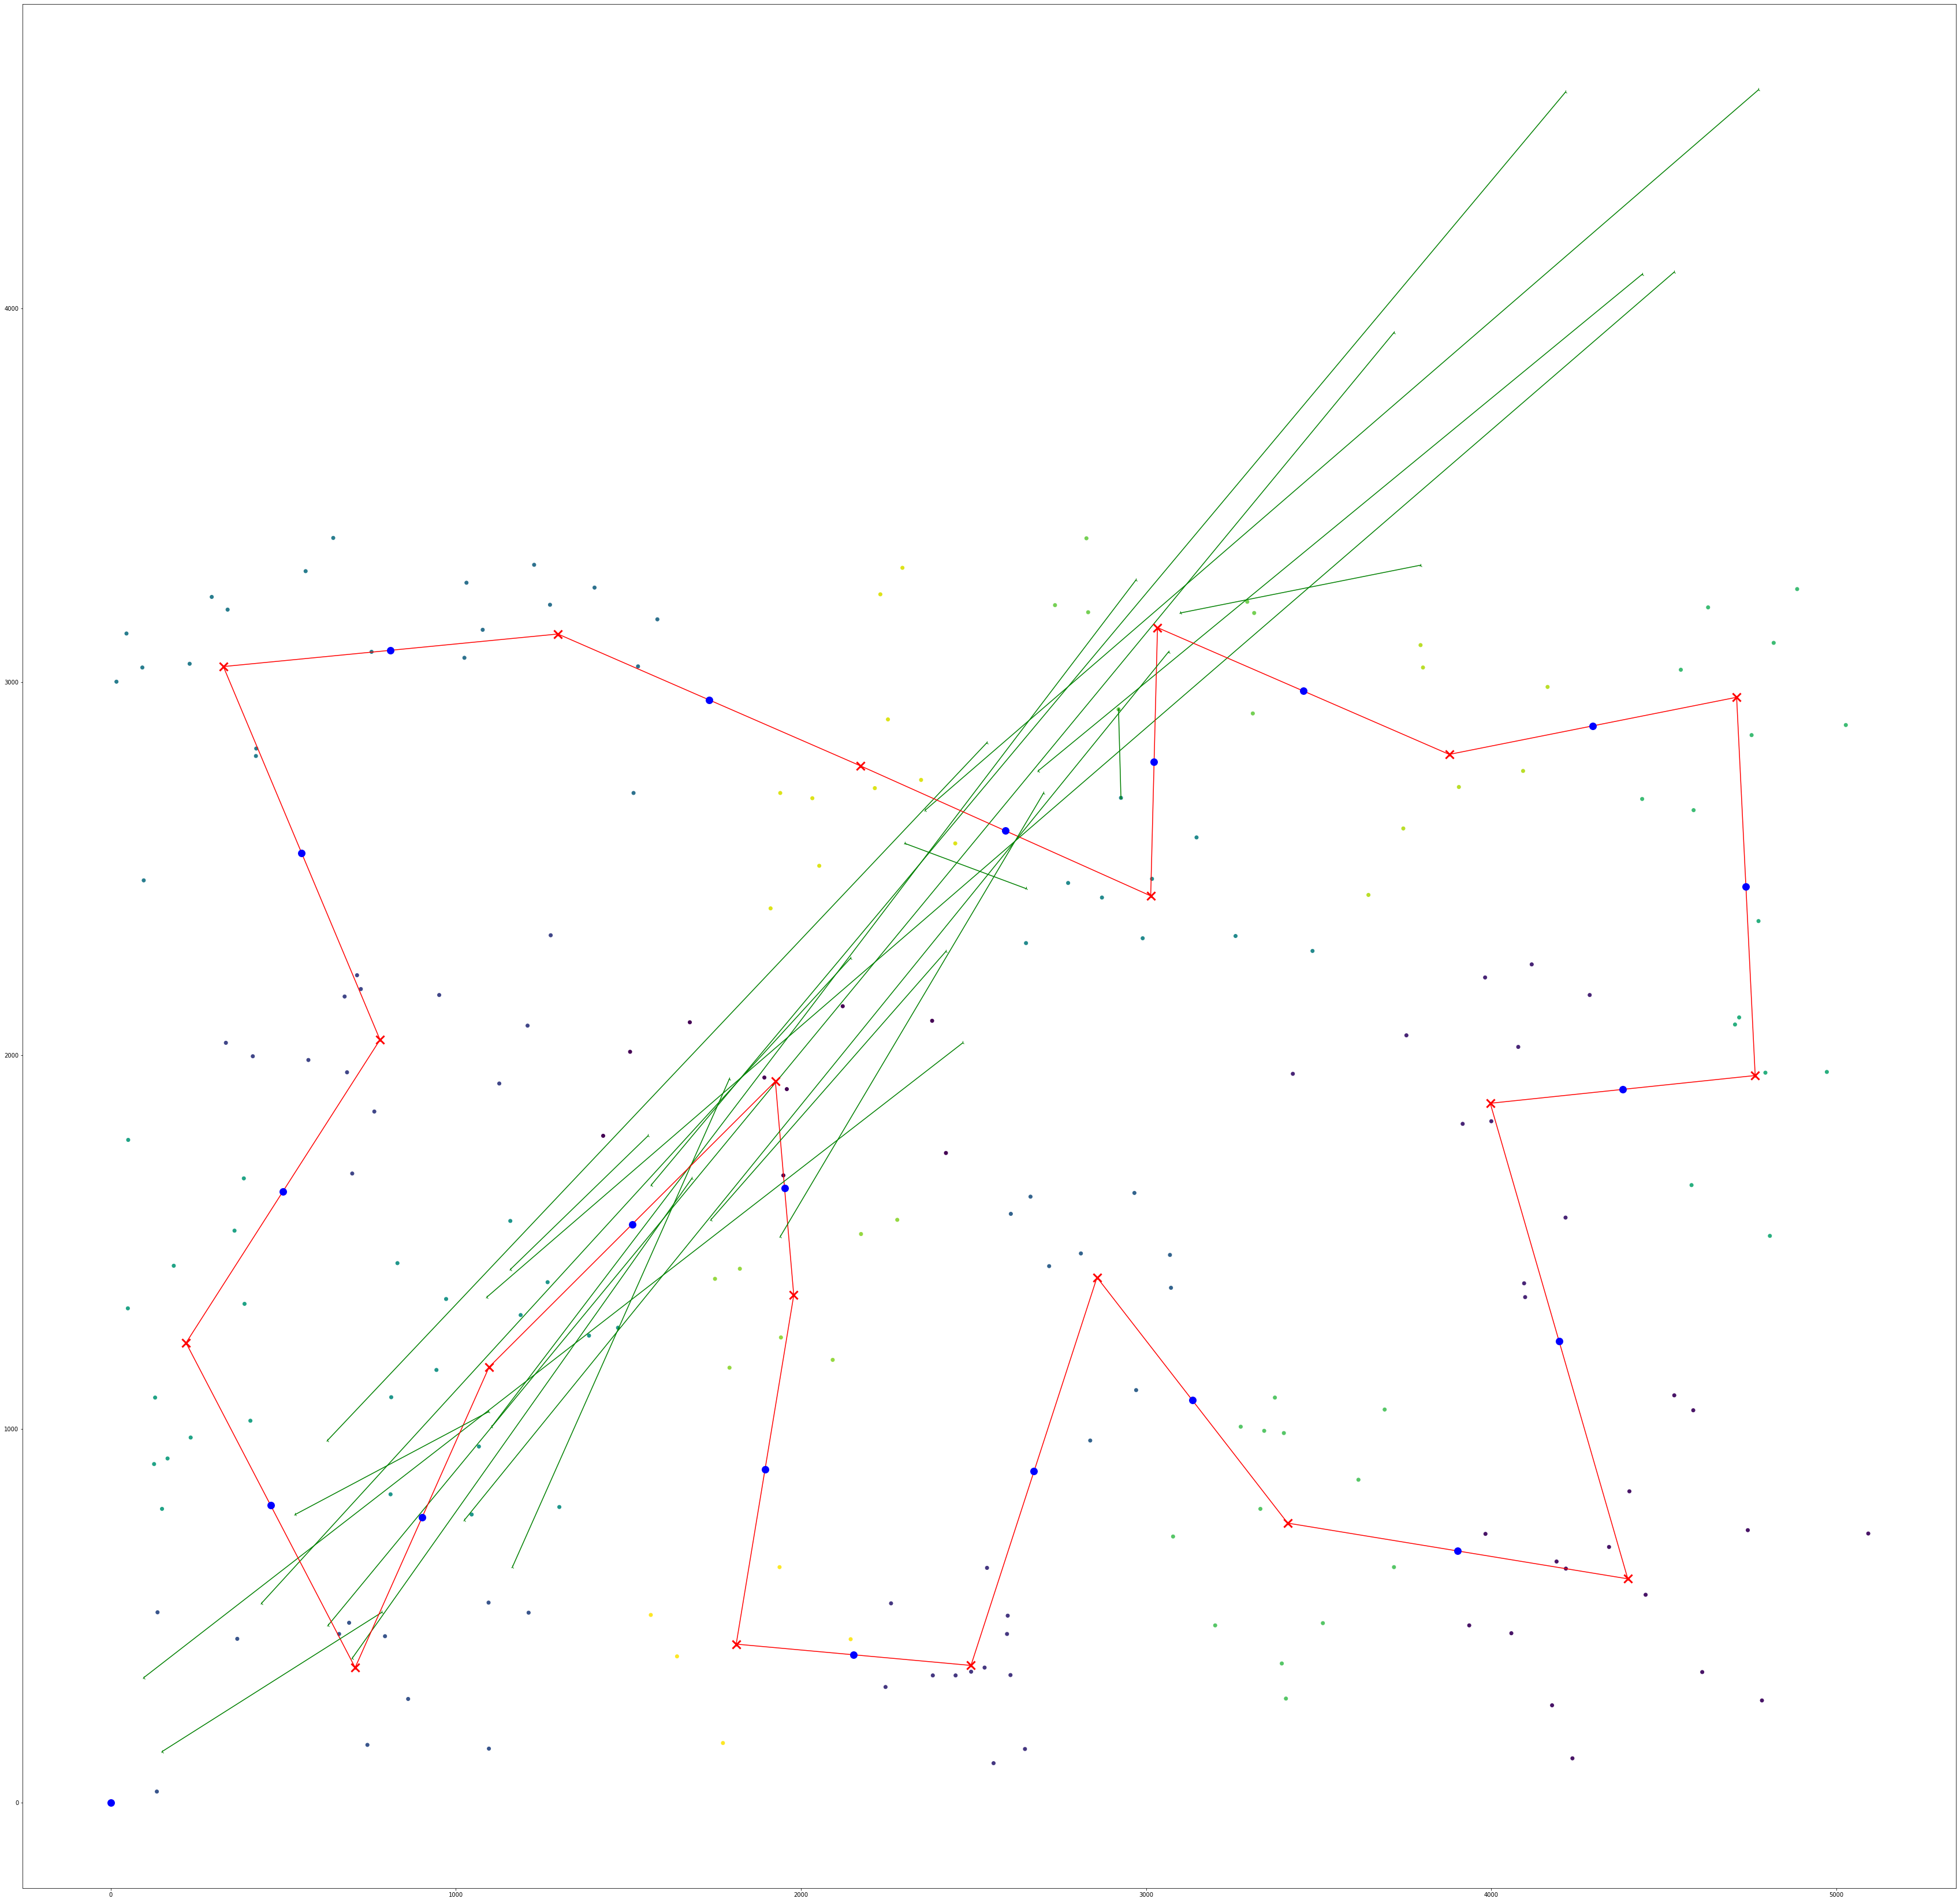

In [22]:
plt.figure(figsize=(60,60))

# nodes
plt.scatter(x=chimneys['X'], y=chimneys['Y'], c=chimneys['cluster'])
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="x", s=200, linewidths=3, c='r', zorder=10)
plt.scatter(x=halfways[:, 0], y=halfways[:, 1], marker="o", s=100, linewidths=3, c='b', zorder=10)

ctr = centroids_tsp_route[0]

# lines
for i in range(len(ctr)-1):
    a = ctr[i]
    b = ctr[i+1]
    plt.plot([centroids[a][0], centroids[b][0]], [centroids[a][1], centroids[b][1]], marker="1", c='r')
    plt.plot([links[i][0], links[i][1]], [links[i][2], links[i][3]], marker="2", c='g')
    
plt.show()

In [23]:
links

[[2420, 1739, 2279, 1560],
 [1793, 1164, 1938, 630],
 [2144, 437, 2261, 533],
 [2539, 628, 2838, 969],
 [2971, 1104, 3274, 1006],
 [3718, 630, 3936, 474],
 [4530, 1090, 4098, 1353],
 [4215, 1566, 4580, 1653],
 [4774, 2360, 4586, 2657],
 [4437, 2687, 4092, 2762],
 [3795, 3099, 3313, 3185],
 [2920, 2927, 2927, 2690],
 [2652, 2301, 2447, 2568],
 [1940, 2703, 1515, 2703],
 [1025, 3065, 756, 3081],
 [96, 2469, 334, 2034],
 [700, 1684, 386, 1671],
 [149, 786, 136, 509],
 [1095, 535, 1046, 771],
 [1158, 1557, 1427, 1785]]

In [24]:
chimneys.head(10)

,X,Y,cluster
0,1031,3266,7
1,4754,2858,13
2,1078,3140,7
3,2920,2927,15
4,412,1998,4
5,2245,309,3
6,764,1850,4
7,4095,1390,2
8,2294,3306,18
9,4092,2762,17


In [25]:
chimneys[chimneys['cluster'] == 0]

,X,Y,cluster
43,1427,1785,0
60,1505,2010,0
87,2380,2093,0
92,2420,1739,0
96,1959,1910,0
97,1678,2089,0
123,2121,2132,0
163,1894,1941,0
164,1949,1679,0


In [26]:
chimneys[chimneys['cluster'] == 6]


,X,Y,cluster
38,3072,1378,6
56,2719,1436,6
98,2665,1622,6
100,2608,1576,6
102,2811,1470,6
126,2838,969,6
136,2966,1632,6
165,3069,1466,6
199,2971,1104,6


In [27]:
# get the route around the centroids
route = np.arange(len(centroids))
distances = np.arange(len(centroids))
    
def calculate_tour_distance(journey, cdm):

    my_distances = np.arange(0, len(journey), dtype=float)
    
    for i in range(len(journey)-1):
        
        a = journey[i]
        b = journey[i+1]
        
        c = len(journey)-1
        
        
        
        my_distances[i] = cdm[a][b]  
        #print(a, b, c, my_distances[i])
        
    my_distances[c] = cdm[journey[0]][journey[c]]
    
    return my_distances

distances = calculate_tour_distance(route, cdm)

print(route)
print(distances)
print(np.sum(distances))
#print(route2)
#print(distances2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[2805.90844354 1334.29056918 2128.21473667 2395.47730147 1682.77208987
 2389.75009825 2325.31999922  973.05098208 2755.75710578 2295.02988433
  880.13686351 4601.86302856 1014.24951095 2565.48870026 2427.49901463
 2075.14726303 2388.16220862 1706.11703561 2379.27754161 1511.35589684]
42634.868274016306


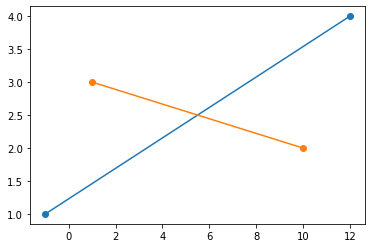

In [28]:
x1, y1 = [-1, 12], [1, 4]
x2, y2 = [1, 10], [3, 2]
plt.plot(x1, y1, x2, y2, marker = 'o')
#plt.plot(x1, y1)
plt.show()

In [29]:
def update_tour(route2, distances2, cdm, i, j):
    
    # what are the minimum number of calculations needed to be made to recalculate the distances array for the route
    # based on a pairwise swap operator
    #print(i, j)
    
    # update the route with a simple swap
    t = route2[i]
    route2[i] = route2[j]
    route2[j] = t
    
    # now calculate the revised distances
    if i == 0:
        distances2[len(route2)-1] = cdm[route2[len(route2)-1]][route2[i]]
        distances2[i] = cdm[route2[i]][route2[i+1]]
        distances2[i+1] = cdm[route2[i+1]][route2[i+2]]
    elif i == len(route2)-1:
        distances2[i-1] = cdm[route2[i-1]][route2[i]]
        distances2[i] = cdm[route2[i]][route2[0]]
        distances2[0] = cdm[route2[0]][route2[1]]
    elif i == len(route2)-2:
        distances2[i-1] = cdm[route2[i-1]][route2[i]]
        distances2[i] = cdm[route2[i]][route2[i+1]]
        distances2[i+1] = cdm[route2[i+1]][route2[0]]
    else:  
        distances2[i-1] = cdm[route2[i-1]][route2[i]]
        distances2[i] = cdm[route2[i]][route2[i+1]]
        distances2[i+1] = cdm[route2[i+1]][route2[i+2]]
    
    
    if j == 0:
        distances2[len(route2)-1] = cdm[route2[len(route2)-1]][route2[j]]
        distances2[j] = cdm[route2[j]][route2[j+1]]
        distances2[j+1] = cdm[route2[j+1]][route2[j+2]]
    elif j == len(route2)-1:
        distances2[j-1] = cdm[route2[j-1]][route2[j]]
        distances2[j] = cdm[route2[j]][route2[0]]
        distances2[0] = cdm[route2[0]][route2[1]]
    elif j == len(route2)-2:
        distances2[j-1] = cdm[route2[j-1]][route2[j]]
        distances2[j] = cdm[route2[j]][route2[j+1]]
        distances2[j+1] = cdm[route2[j+1]][route2[0]]
    else:  
        distances2[j-1] = cdm[route2[j-1]][route2[j]]
        distances2[j] = cdm[route2[j]][route2[j+1]]
        distances2[j+1] = cdm[route2[j+1]][route2[j+2]]
            
            

    return route2, distances2

route2 = route.copy()
distances2 = distances.copy()
 
route2, distances2 = update_tour(route2, distances2, cdm, 0, 3)

print(route2)
print(distances2)
print(np.sum(distances2))

[ 3  1  2  0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1916.95807714 1334.29056918 2071.85469558 1150.82615083 1682.77208987
 2389.75009825 2325.31999922  973.05098208 2755.75710578 2295.02988433
  880.13686351 4601.86302856 1014.24951095 2565.48870026 2427.49901463
 2075.14726303 2388.16220862 1706.11703561 2379.27754161  682.48861712]
39616.03943616896


In [30]:

i = np.random.randint(len(route))
j = np.random.randint(len(route))
update_tour(route2, distances2, cdm, i,j)


print(route)
print(distances)
print(np.sum(distances))
print(route2)
print(distances2)
print(np.sum(distances2))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[2805.90844354 1334.29056918 2128.21473667 2395.47730147 1682.77208987
 2389.75009825 2325.31999922  973.05098208 2755.75710578 2295.02988433
  880.13686351 4601.86302856 1014.24951095 2565.48870026 2427.49901463
 2075.14726303 2388.16220862 1706.11703561 2379.27754161 1511.35589684]
42634.868274016306
[ 3  1  2  0  4  5  6 13  8  9 10 11 12  7 14 15 16 17 18 19]
[1916.95807714 1334.29056918 2071.85469558 1150.82615083 1682.77208987
 2389.75009825 2417.92996726 4384.6465169  2755.75710578 2295.02988433
  880.13686351 4601.86302856 3664.48556324 3184.0379015  2427.49901463
 2075.14726303 2388.16220862 1706.11703561 2379.27754161  682.48861712]
46389.03019254286


In [31]:
# greedy move


def get_closest_nbrs_N(r, N, route, cdm):
    
    # add the the list of nearest neighbours of r
    neighbours = [r]
    #closest = pd.DataFrame()

    # find the closest N non-neighbours
    for n in range(N):
        dist = 1e6
        closest = -1
        for p in range(len(route)):
            if p not in neighbours:
                d = cdm[r][p]
                if d < dist:
                    dist = d
                    closest = p
        neighbours.append(closest)
    
    print(neighbours)
            
    return neighbours


print(len(route))

# select a random chimney
closest = get_closest_nbrs_N(0, 3, route, cdm)
print(closest)


20
[0, 16, 18, 6]
[0, 16, 18, 6]


In [32]:
# greedy move


def get_closest_nbrs_within(r, within, route):
    # add the the list of nearest neighbours
    neighbours = []
    neighbours.append(r)
    #print(r)

    #print(chimneys)
    closest = pd.DataFrame()
    row = pd.Series({'X':chimneys.iloc[r,0],'Y':chimneys.iloc[r,1]},name=r)
    closest = closest.append(row)

    neighbours = [r]

    # find the non-neighbour in range

    for p in range(len(route)):
        d = np.sqrt((chimneys.iat[r,0] - chimneys.iat[p,0])**2 + (chimneys.iat[r,1] - chimneys.iat[p,1])**2)
        #print(r, p, d)
        if p in neighbours:
            pass
        else:
            if d < within:
                neighbours.append(p)
                row = pd.Series({'X':chimneys.iloc[p,0],'Y':chimneys.iloc[p,1]},name=p)
                closest = closest.append(row)

    return closest


route = list(range(0, len(chimneys)))

# select a random chimney
r = np.random.randint(0, len(chimneys))

closest = get_closest_nbrs_within(r, 500, route)
print(closest)


          X       Y
12   3982.0  2209.0
32   4000.0  1824.0
44   4117.0  2244.0
55   3644.0  2430.0
69   4285.0  2162.0
83   3754.0  2054.0
93   3917.0  1817.0
129  3745.0  2608.0
197  4078.0  2023.0


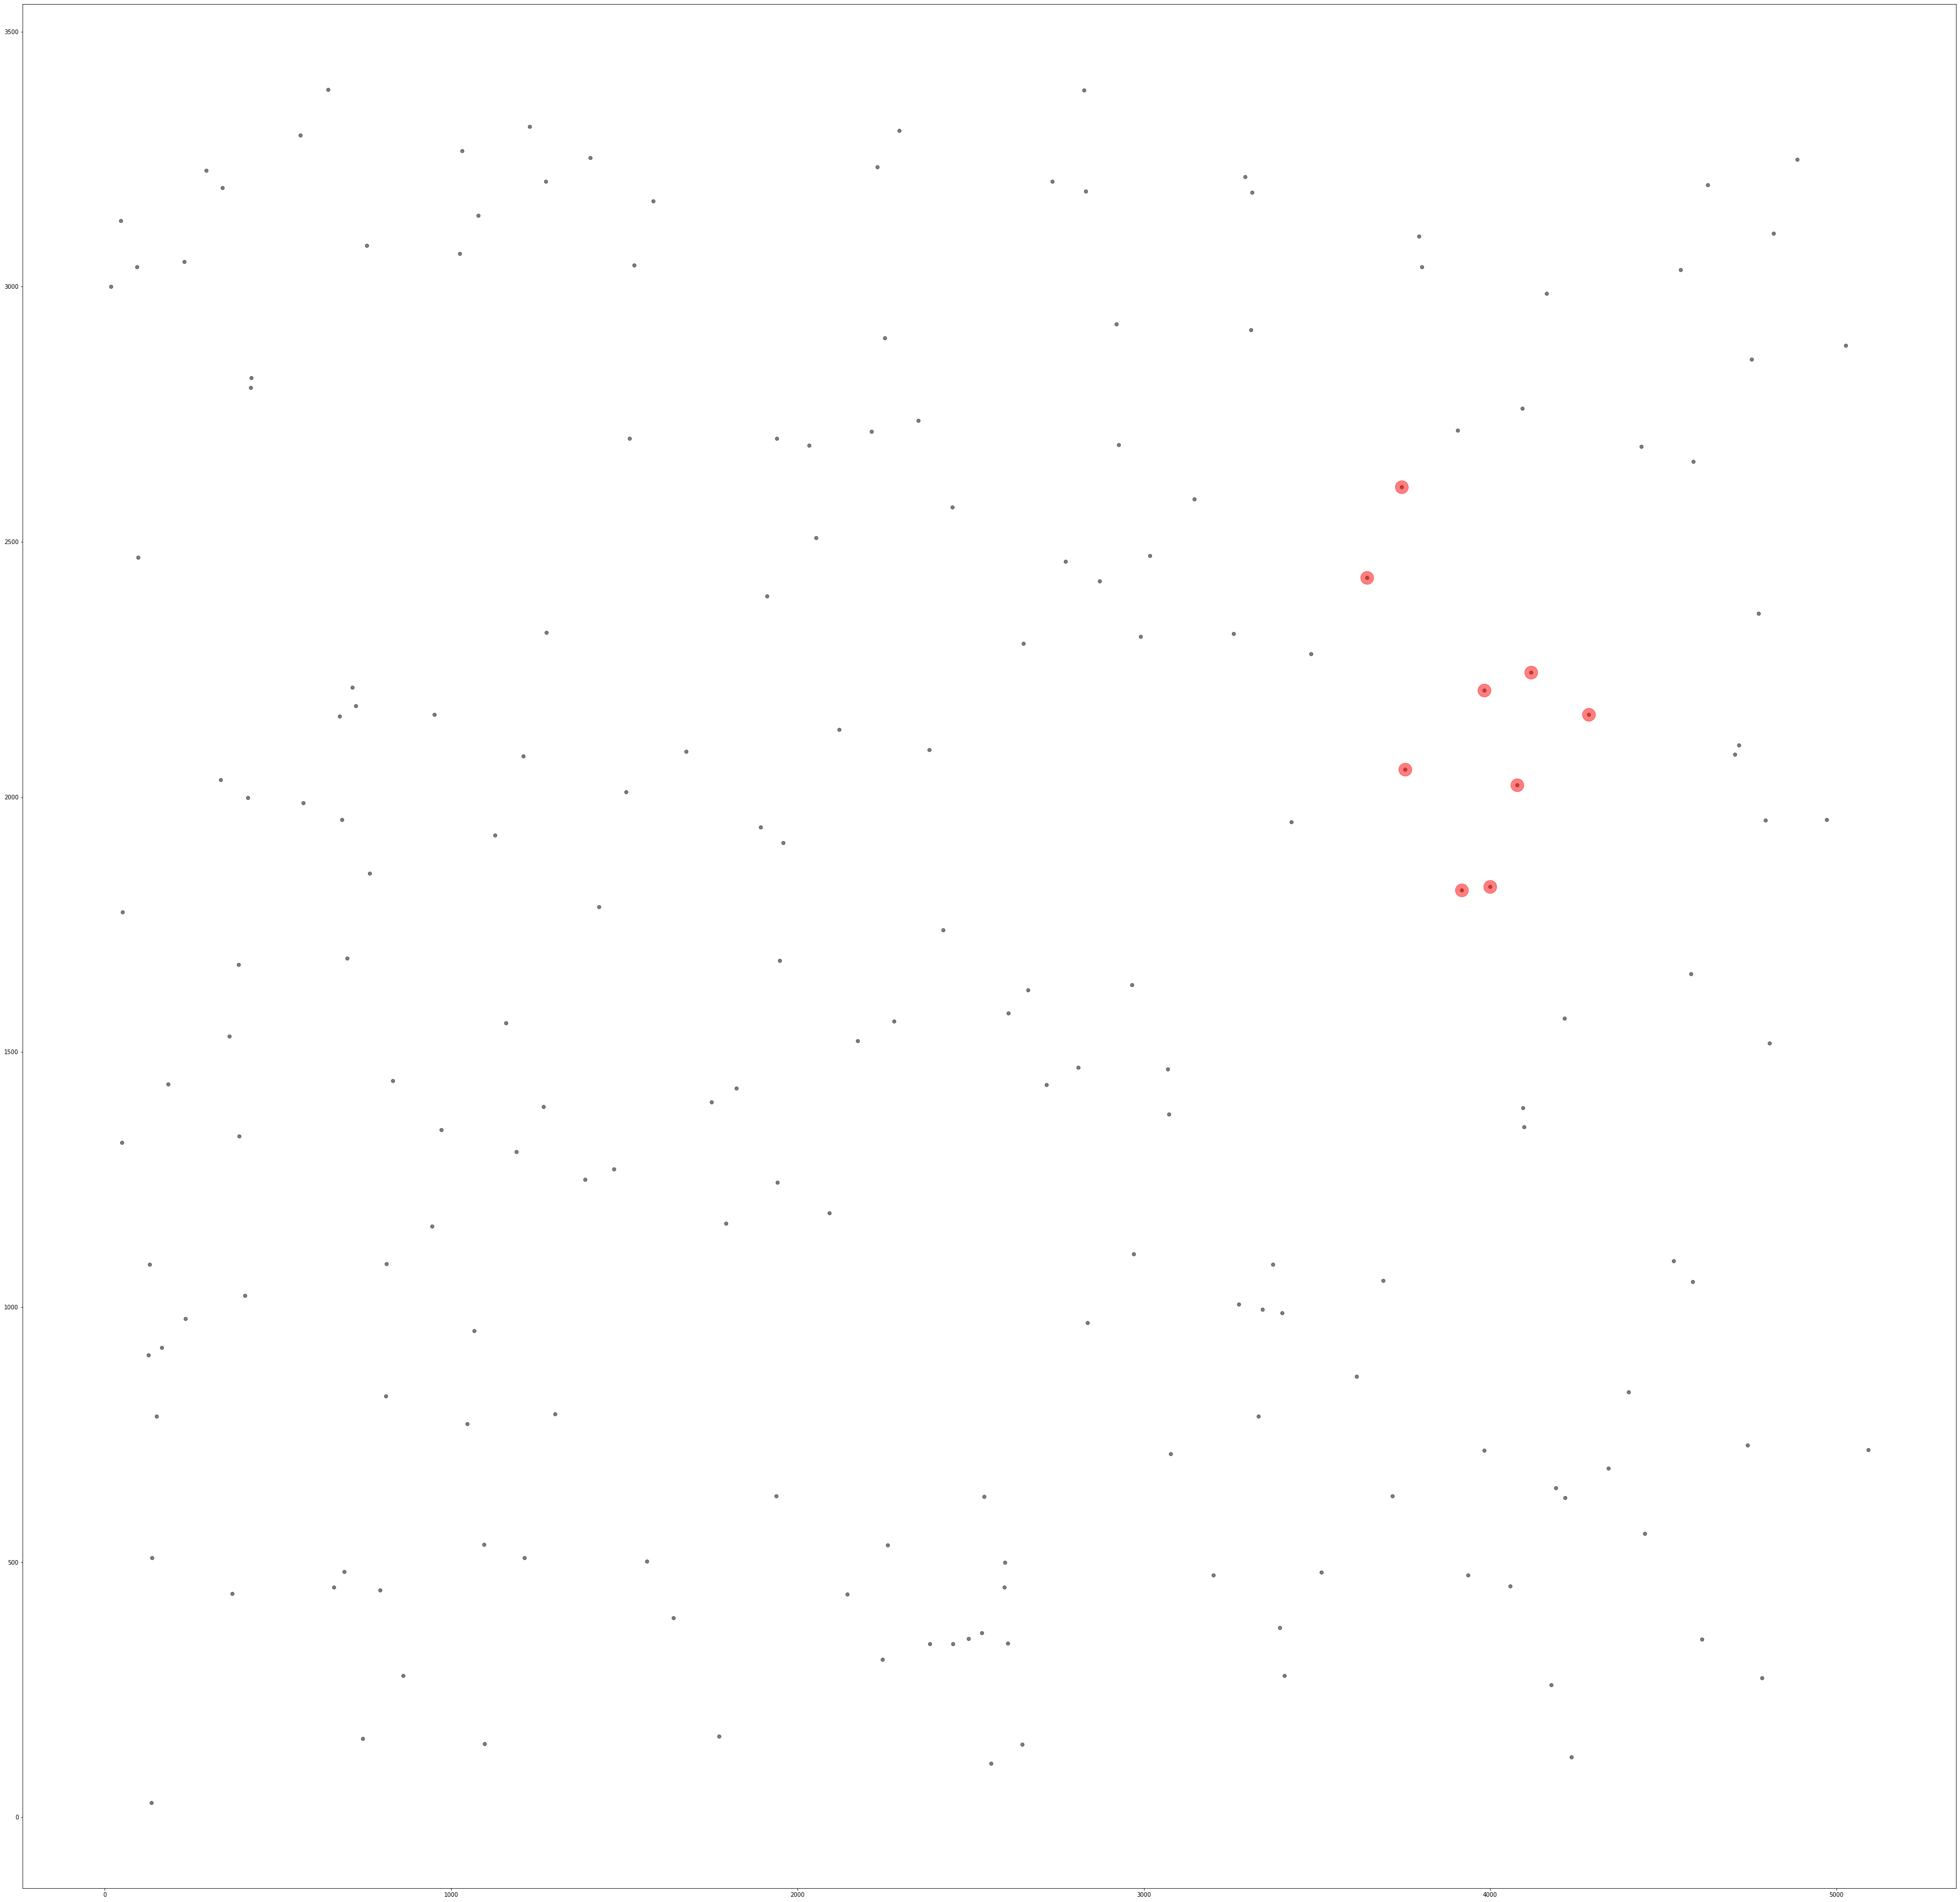

In [33]:
plt.figure(figsize=(60,60))
plt.scatter(chimneys['X'], chimneys['Y'], alpha=0.5, color='k')
plt.scatter(closest['X'], closest['Y'], alpha=0.5, s=500, color='red')
plt.show()

In [34]:
def find_greedy_shortest_route(nbrs):
    
    shortest_route = []
    
    print(len(nbrs), nbrs)
    
    gsr = [0]
    
    for i in range(len(nbrs)-1):
        dist = 1000000
        c = -1
        for j in range(len(nbrs)):
            if j not in gsr:
                d = np.sqrt((nbrs.iat[gsr[-1],0] - nbrs.iat[j,0])**2 + (nbrs.iat[gsr[-1],1] - nbrs.iat[j,1])**2)
                if d < dist:
                    c = j
                    dist = d
    
        gsr.append(c)
        
    idx = nbrs.index
    
    # translate to the indices of the nbrs
    for i in range(len(gsr)):
        gsr[i] = idx[i]
    
    return gsr

gsr = find_greedy_shortest_route(closest)
print(gsr)
    

9           X       Y
12   3982.0  2209.0
32   4000.0  1824.0
44   4117.0  2244.0
55   3644.0  2430.0
69   4285.0  2162.0
83   3754.0  2054.0
93   3917.0  1817.0
129  3745.0  2608.0
197  4078.0  2023.0
[12, 32, 44, 55, 69, 83, 93, 129, 197]


In [35]:
def insert_sub_path(olp, nwp):
    
    #print(nwp)
    
    for i in range(1, len(nwp)):
        if nwp[i] in olp:
            olp.remove(nwp[i])

    c = olp.index(nwp[0])
    
    for i in range(1, len(nwp)):
        olp.insert((i+c), nwp[i])
    
    return(olp)
    
print(route, gsr)
    
result = insert_sub_path(route, gsr)
print(result)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] [12, 32, 44, 55, 69, 83, 93, 129, 197]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 32, 44, 55, 69, 83, 93, 129

In [36]:
for x in range(100):
    
    d = np.random.randint(100, 500)
    r = np.random.randint(0, len(route))
    nbrs = get_closest_nbrs_within(r, d, route)
    gsr = find_greedy_shortest_route(nbrs)
    route = insert_sub_path(route, gsr)
    

5           X       Y
3    2920.0  2927.0
54   2832.0  3187.0
111  2927.0  2690.0
144  2736.0  3206.0
190  3309.0  2916.0
1           X       Y
108  2827.0  3385.0
5           X       Y
39   1823.0  1429.0
26   1942.0  1245.0
86   1793.0  1164.0
89   1751.0  1402.0
164  1949.0  1679.0
4           X       Y
97   1678.0  2089.0
60   1505.0  2010.0
96   1959.0  1910.0
163  1894.0  1941.0
1          X      Y
41  4743.0  729.0
3           X      Y
191  4176.0  260.0
131  4058.0  453.0
161  4235.0  118.0
5          X       Y
125  165.0   921.0
27   232.0   977.0
116  149.0   786.0
130  126.0   906.0
170  129.0  1084.0
9          X       Y
150  678.0  2158.0
4    412.0  1998.0
6    764.0  1850.0
22   685.0  1955.0
70   952.0  2162.0
81   714.0  2215.0
155  573.0  1988.0
159  334.0  2034.0
176  725.0  2178.0
6           X      Y
29   3200.0  474.0
36   3512.0  480.0
106  3393.0  372.0
158  3331.0  786.0
184  3078.0  712.0
185  3405.0  278.0
5          X       Y
114  565.0  3297.0
28   339.0  3

3           X       Y
7    4095.0  1390.0
75   4215.0  1566.0
138  4098.0  1353.0
2           X      Y
29   3200.0  474.0
106  3393.0  372.0
1          X       Y
64  1158.0  1557.0
2         X       Y
77  421.0  2802.0
95  422.0  2822.0
3           X       Y
178  2092.0  1185.0
26   1942.0  1245.0
86   1793.0  1164.0
2           X       Y
14   3313.0  3185.0
171  3293.0  3215.0
2           X      Y
137  1211.0  508.0
61   1095.0  535.0
4           X      Y
157  1641.0  391.0
23   1938.0  630.0
135  1565.0  502.0
146  1774.0  159.0
2           X       Y
172  4818.0  3105.0
160  4886.0  3249.0
3          X       Y
28   339.0  3194.0
85   229.0  3049.0
152  293.0  3228.0
13           X      Y
105  2382.0  340.0
5    2245.0  309.0
13   2539.0  628.0
19   2261.0  533.0
20   2649.0  143.0
53   2532.0  361.0
59   2599.0  500.0
74   2597.0  451.0
99   2144.0  437.0
110  2493.0  350.0
117  2607.0  341.0
139  2448.0  340.0
192  2558.0  105.0
8           X       Y
196  1940.0  2703.0
40   2214.0 

In [37]:
# iterative random improvement
for i in range(1000):

    a = np.random.randint(len(route))
    b = np.random.randint(len(route))

    update_tour(a, b)

    if np.sum(distances2) <= np.sum(distances):
        route = route2.copy()
        distances = distances2.copy()
    else:
        route2 = route.copy()
        distances2 = distances.copy()

    #print(i,'\t',a,'\t',b,'\t',np.sum(distances))
    
print(np.sum(distances))
print(route)

TypeError: update_tour() missing 3 required positional arguments: 'cdm', 'i', and 'j'

In [ ]:
# local search

# create orderings for chimney exchanges in the route
order_a = np.arange(len(route))
order_b = np.arange(len(route))
i=0

change = 1
while(change == 1):
    change = 0
    
    # randomise the ordering to eliminate any bias
    np.random.shuffle(order_a)
    np.random.shuffle(order_b)
    
    for a in range(len(route)):
        for b in range(len(route)):

            if a != b:
                update_tour(order_a[a], order_b[b])

                if np.sum(distances2) < np.sum(distances):
                    route = route2.copy()
                    distances = distances2.copy()
                    change = 1
                else:
                    route2 = route.copy()
                    distances2 = distances.copy()

                #print(i,'\t',order_a[a],'\t',order_b[b],'\t',np.sum(distances))
                i+=1
                
print(np.sum(distances))
print(route)

In [ ]:
# iterated local search

# create orderings for chimney exchanges in the route
order_a = np.arange(len(route))
order_b = np.arange(len(route))
i=0

best_route = route.copy()
best_distances = distances.copy()

#x = int(np.floor(len(route)/2))
x = np.random.randint(np.floor(len(route)/2))

for iter in range(5):
    
    # make x random changes
    for i in range(x):
        a = np.random.randint(len(route))
        b = np.random.randint(len(route))

        update_tour(a, b)

        route = route2.copy()
        distances = distances2.copy()
    
    change = 1
    while(change == 1):
        change = 0

        # randomise the ordering to eliminate any bias
        np.random.shuffle(order_a)
        np.random.shuffle(order_b)

        for a in range(len(route)):
            for b in range(len(route)):

                if a != b:
                    update_tour(order_a[a], order_b[b])

                    if np.sum(distances2) < np.sum(distances):
                        route = route2.copy()
                        distances = distances2.copy()
                        change = 1
                    else:
                        route2 = route.copy()
                        distances2 = distances.copy()

                    #print(i,'\t',order_a[a],'\t',order_b[b],'\t',np.sum(distances))
                    i+=1
                
    if np.sum(distances) < np.sum(best_distances):
        best_route = route.copy()
        best_distances = distances.copy()
                
    print('{}\t{}'.format(iter, np.sum(best_distances)))
    
print(np.sum(best_distances))
print(best_route)

In [ ]:
from matplotlib.lines import Line2D

# draw the route
def draw_route(journey):
    
    print(journey)
    
    fig = plt.figure(figsize=(60,60))
    sns.scatterplot(chimneys['X'], chimneys['Y'], alpha=0.5, color='k')
    
    #fig = plt.figure(figsize=(60,60))
    ax = fig.add_subplot(111)
    
    x = []
    y = []
    
    for i in range(len(journey)):
        print(journey[i])
        print(chimneys.iloc[journey[i],:])
        x.append(chimneys.iloc[journey[i],0])
        y.append(chimneys.iloc[journey[i],1])
    # and back to start
    #x.append(chimneys.iloc[journey[0],0])
    #y.append(chimneys.iloc[journey[0],1])
        
    #print(x)
    line = Line2D(x,y)
    ax.add_line(line)
    
    ax.set_xlim(0, 4999)
    ax.set_ylim(0, 4999)
    
    
    
    plt.show()
    
draw_route(gsr)

In [ ]:
# which node begins the longest step
s = np.amax(distances)
print(s)

In [ ]:
# dijkstra's algorithm

# https://stackoverflow.com/questions/22897209/dijkstras-algorithm-in-python


nodes = ('A', 'B', 'C', 'D', 'E', 'F', 'G')
distances = {
    'B': {'A': 5, 'D': 1, 'G': 2},
    'A': {'B': 5, 'D': 3, 'E': 12, 'F' :5},
    'D': {'B': 1, 'G': 1, 'E': 1, 'A': 3},
    'G': {'B': 2, 'D': 1, 'C': 2},
    'C': {'G': 2, 'E': 1, 'F': 16},
    'E': {'A': 12, 'D': 1, 'C': 1, 'F': 2},
    'F': {'A': 5, 'E': 2, 'C': 16}}

unvisited = {node: None for node in nodes} #using None as +inf
visited = {}
current = 'B'
currentDistance = 0
unvisited[current] = currentDistance

while True:
    for neighbour, distance in distances[current].items():
        if neighbour not in unvisited: continue
        newDistance = currentDistance + distance
        if unvisited[neighbour] is None or unvisited[neighbour] > newDistance:
            unvisited[neighbour] = newDistance
    visited[current] = currentDistance
    del unvisited[current]
    if not unvisited: break
    candidates = [node for node in unvisited.items() if node[1]]
    current, currentDistance = sorted(candidates, key = lambda x: x[1])[0]

print(visited)

In [ ]:

nodes = np.array(np.arange(0,100))

distances = np.zeros((len(nodes),len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            distances[i][j] = np.random.randint(200)
        distances[j][i] = distances[i][j]
        
distances

In [ ]:
# create a sorted list of links

from operator import itemgetter

links = []
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            links.append([i, j, distances[i][j]])
        
links = sorted(links, key=itemgetter(2), reverse=True)
links

In [ ]:
# get a list of the potential paths

potential_paths = []



In [ ]:
# return the GREEDIEST choice to the next node - to be used as g

def get_g(S, unvisited, links):
    
    # set for error case, overwrite with greediest path
    a = [-1, -1, -1]
    
    # run from bottom of links looking for easiest node to mode to
    for i in range(len(links)-1, 0, -1):
        if links[i][0] == S and links[i][1] in unvisited:
            a = links[i].copy()
            break
    
    return a

g = get_g(0, [1,2,3,4,5,6,7,8], links)
g

In [ ]:
# return the MOST EXPENSIVE route through the unvisited nodes - to be used as h heuristic

# the zeroth element of unvisited is ALWAYS the final node
def get_h(L, unvisited, links):
    
    most_expensive_path = []
    
    h = 0
    
    # find the most expensive unvisited link to the destination node L
    for i in range(len(links)):
        if links[i][1] == L and links[i][0] in unvisited:
            h += links[i][2]
            most_expensive_path.append(links[i])
            
            unvisited.remove(links[i][0])
            break
            
    while len(unvisited) > 0:
        
        L = most_expensive_path[len(most_expensive_path)-1][0]

        for i in range(len(links)):
            if links[i][1] == L and links[i][0] in unvisited:
                h += links[i][2]
                most_expensive_path.append(links[i])

                unvisited.remove(links[i][0])
                break
        
    return h, most_expensive_path, unvisited

h, mep, unvisited = get_h(9, [1,2,3,4,5,6,7,8], links)

print(mep)
print(h)
print(unvisited)

In [ ]:
paths = []

# create random start and last nodes
S = np.random.randint(0, len(nodes))
D = np.random.randint(0, len(nodes))
while S == D:
    D = np.random.randint(0, len(nodes))
print(S, D)

unvisited = list(np.arange(0, len(nodes)))
unvisited.remove(S)
unvisited.remove(D)
print(unvisited)


In [ ]:
# A* style search
route = [S]

paths = []

for i in range(len(unvisited)):
    
    n = unvisited[i]
    u2 = unvisited.copy().remove(n)
    
    s = route[len(route)-1]
    g = distances[s][n]
    h = get_h(D, u2, links)
    
    paths.append([route.append(n), h, g, h+g])